In [452]:
import random
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


from matplotlib import pyplot as plt, animation

In [453]:
seed = 44
random.seed(seed)
torch.manual_seed(seed=seed)

In [454]:
root_dir = './datasets/'
batch_size = 128
image_size = 28
num_channels = 1
num_latent = 100
num_g_feature = 28
num_d_feature = 28
epochs = 10
learning_rate = 0.0002
beta1 = 0.5
num_gpu = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [455]:
dataset = torchvision.datasets.MNIST(root=root_dir, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

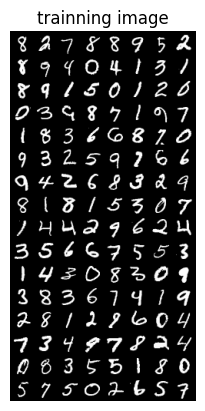

In [456]:
real_batch = next(iter(dataloader))
plt.axis('off')
plt.title('trainning image')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size],
                                         padding=2,
                                         normalize=True).cpu(),
                        (1,2,0)))

In [457]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [458]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        # input: 1 x 28 x 28
        self.conv1 = nn.Conv2d(num_channels, 32, 4, 2, 1, bias=False)
        self.leakyRelu1 = nn.LeakyReLU(0.2, inplace=True)
        # output: 32 x 14 x 14
        
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias=False)
        self.leakyRelu2 = nn.LeakyReLU(0.2, inplace=True)
        # output: 64 x 7 x 7
        
        self.fc1 = nn.Linear(64*7*7, 512)
        self.leakyRelu3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.leakyRelu1(x)
        x = self.conv2(x)
        x = self.leakyRelu2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.leakyRelu3(x)
        
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [459]:
net_d = Discriminator().to(device)
net_d.apply(weights_init)
net_d

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyRelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyRelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (leakyRelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [460]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        # input 100 x 1 x 1
        self.convt1 = nn.ConvTranspose2d(num_latent, 128, 4, 2, 0, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU(inplace=True)
        # output: 128 x 4 x 4
        
        self.convt2 = nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        # output: 64 x 7 x 7
        
        self.convt3 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(32)
        self.relu3  =nn.ReLU()
        # output: 32 x 14 x 14
        
        self.convt4 = nn.ConvTranspose2d(32, num_channels, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()
        # output: 1 x 28 x 28
        
    def forward(self, x: torch.Tensor):
        x = self.convt1(x)
        x = self.batchNorm1(x)
        x = self.relu1(x)
        
        x = self.convt2(x)
        x = self.batchNorm2(x)
        x = self.relu2(x)
        
        x = self.convt3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        
        x = self.convt4(x)
        output = self.tanh(x)
        return output
    

In [461]:
net_g = Generator().to(device)
net_g.apply(weights_init)
net_g

Generator(
  (convt1): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (convt2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (convt3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (convt4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

In [462]:
fixed_noise = torch.randn(256, num_latent, 1, 1, device=device)

criterion = nn.BCELoss()
optimizer_d = optim.Adam(net_d.parameters(), 
                         lr=learning_rate, 
                         betas=(beta1, 0.999), 
                         weight_decay=learning_rate/epochs)
optimizer_g = optim.Adam(net_g.parameters(), 
                         lr=learning_rate, 
                         betas=(beta1, 0.999), 
                         weight_decay=learning_rate/epochs)

In [463]:
img_list = []
g_losses = []
d_losses = []
iters = 0

for epoch in range(epochs):
    for idx, (images, labels) in enumerate(dataloader):
        # 1. update D network: maximize log(D(x)) + log(1 - D(G(z)))
        optimizer_d.zero_grad()
        # train real images
        real_img = images.to(device)
        b_size = real_img.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output_real = net_d(real_img).view(-1)
                
        err_d_real = criterion(output_real, label)
        err_d_real.backward()
        d_x = output_real.mean().item()
        
        # train fake images
        noise = torch.randn(b_size, num_latent, 1, 1, device=device)
        fake_img = net_g(noise)
        label.fill_(0)
        output_fake = net_d(fake_img.detach()).view(-1)
                
        err_d_fake = criterion(output_fake, label)
        err_d_fake.backward()
        d_g_z1 = output_fake.mean().item()
        
        err_d = err_d_real + err_d_fake
        optimizer_d.step()
        
        # 2. update G network: maximize log(D(G(z)))
        optimizer_g.zero_grad()
        label.fill_(1)
        output_fake = net_d(fake_img).view(-1)
                
        err_g = criterion(output_fake, label)
        err_g.backward()
        d_g_z2 = output_fake.mean().item()
        
        optimizer_g.step()

        # Output training stats
        if idx % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, idx, len(dataloader),
                     err_d.item(), err_g.item(), d_x, d_g_z1, d_g_z2))
            
            
        # Save Losses for plotting later
        g_losses.append(err_g.item())
        d_losses.append(err_d.item())


        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == epochs-1) and (idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    

[0/10][0/469]	Loss_D: 1.3852	Loss_G: 0.7007	D(x): 0.4959	D(G(z)): 0.4953 / 0.4962
[0/10][50/469]	Loss_D: 0.7428	Loss_G: 0.7466	D(x): 0.9232	D(G(z)): 0.4821 / 0.4759
[0/10][100/469]	Loss_D: 0.8942	Loss_G: 0.8551	D(x): 0.9760	D(G(z)): 0.5774 / 0.4271
[0/10][150/469]	Loss_D: 0.6763	Loss_G: 0.9313	D(x): 0.8872	D(G(z)): 0.4256 / 0.3946
[0/10][200/469]	Loss_D: 0.6954	Loss_G: 0.8639	D(x): 0.7604	D(G(z)): 0.3367 / 0.4241
[0/10][250/469]	Loss_D: 0.5780	Loss_G: 1.2990	D(x): 0.8910	D(G(z)): 0.3672 / 0.2748
[0/10][300/469]	Loss_D: 0.4853	Loss_G: 1.4968	D(x): 0.8734	D(G(z)): 0.2882 / 0.2307
[0/10][350/469]	Loss_D: 0.5941	Loss_G: 1.3951	D(x): 0.9016	D(G(z)): 0.3734 / 0.2604
[0/10][400/469]	Loss_D: 1.1577	Loss_G: 1.7594	D(x): 0.9554	D(G(z)): 0.6233 / 0.1940
[0/10][450/469]	Loss_D: 0.8023	Loss_G: 0.8909	D(x): 0.6358	D(G(z)): 0.2634 / 0.4277
[1/10][0/469]	Loss_D: 0.7668	Loss_G: 1.9326	D(x): 0.8959	D(G(z)): 0.4674 / 0.1531
[1/10][50/469]	Loss_D: 0.9311	Loss_G: 0.3630	D(x): 0.4865	D(G(z)): 0.1309 / 0.706

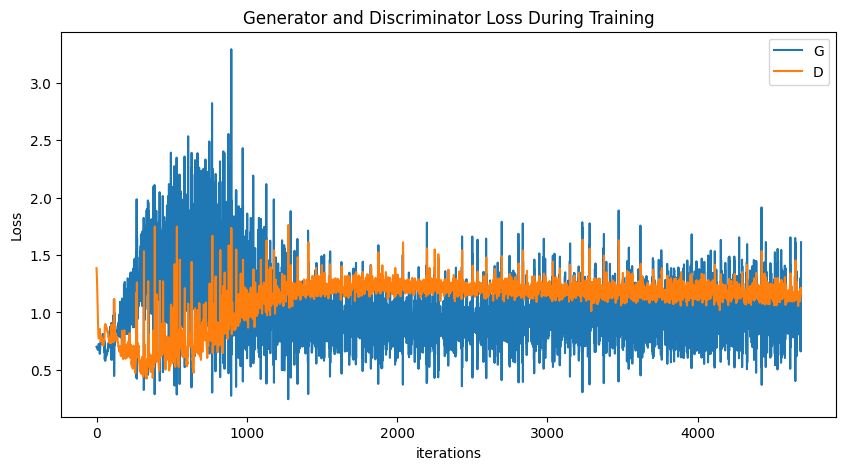

In [464]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

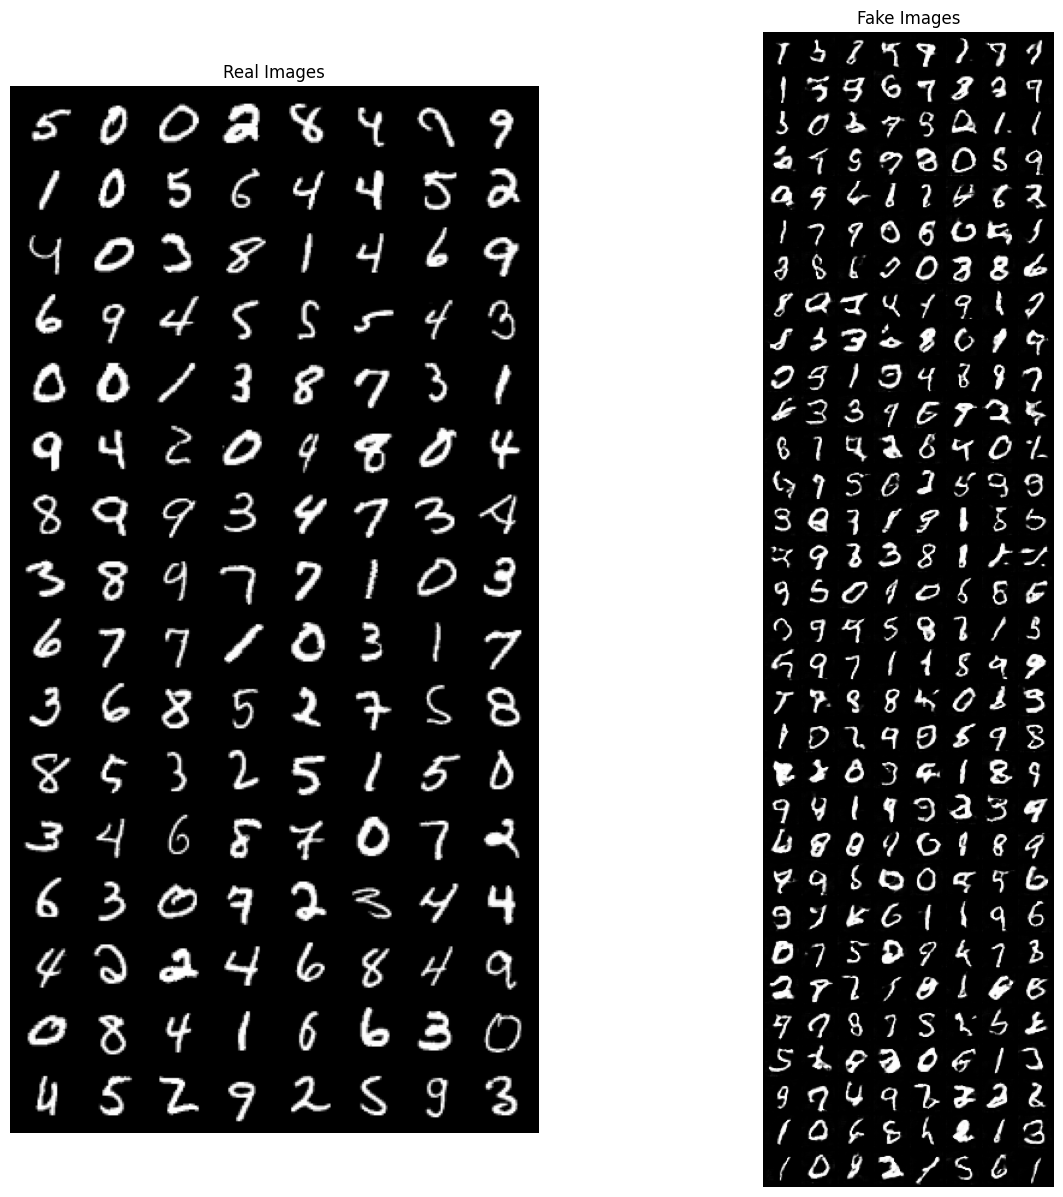

In [465]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()